In [2]:
!pip install tmu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00


In [3]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tmu.models.classification.vanilla_classifier import TMClassifier

ERROR:tmu.clause_bank.clause_bank_cuda:No module named 'pycuda'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tmu/clause_bank/clause_bank_cuda.py", line 41, in <module>
    from pycuda._driver import Device, Context
ModuleNotFoundError: No module named 'pycuda'


# VGG-19 Block 1-2 + Tsetlin Machine for CIFAR-10 Dataset

This notebook implements the first two blocks of VGG-19 architecture followed by Tsetlin Machine to classify the CIFAR-10 dataset.

In [4]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Split training data to create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape labels to 1D arrays
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

print("Load Data Successfully")

print("\nDataset Shapes:")
print(f"Train: features {np.array(X_train).shape}, labels {np.array(y_train).shape}")
print(f"Val: features {np.array(X_val).shape}, labels {np.array(y_val).shape}")
print(f"Test: features {np.array(X_test).shape}, labels {np.array(y_test).shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Load Data Successfully

Dataset Shapes:
Train: features (40000, 32, 32, 3), labels (40000,)
Val: features (10000, 32, 32, 3), labels (10000,)
Test: features (10000, 32, 32, 3), labels (10000,)


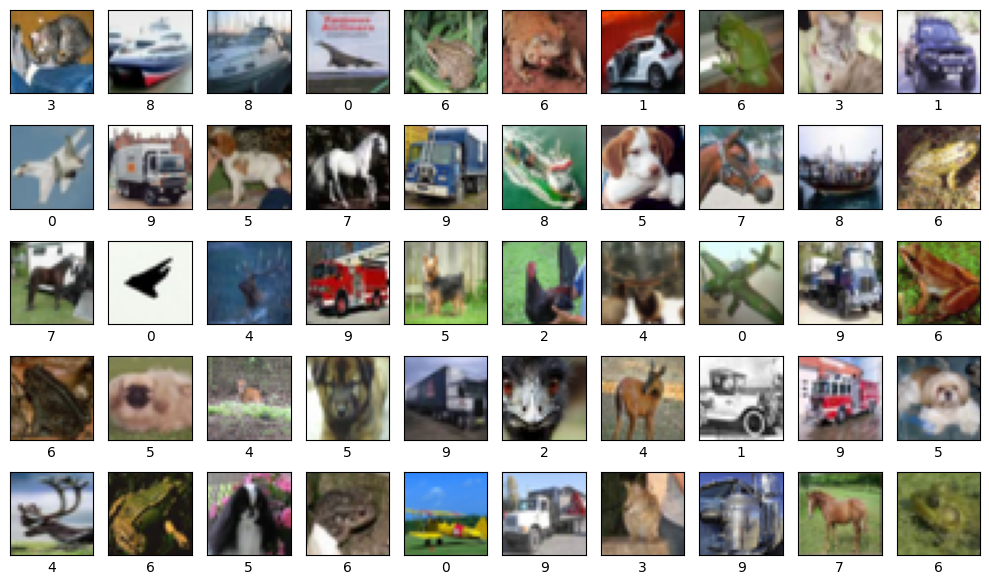

In [5]:
# Visualize some images from the dataset
plt.figure(figsize=(10,6))
for i in range(0,50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.xlabel(y_test[i])
plt.tight_layout()

In [6]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create a mapping from class index to class name
class_mapping = {i: name for i, name in enumerate(class_names)}
print(class_mapping)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [7]:
# Normalize images for CNN (pixel values from [0, 255] to [0, 1])
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

print(f"Input shape: {X_train_norm.shape[1:]}")
print(f"Data type: {X_train_norm.dtype}")
print(f"Value range: [{X_train_norm.min()}, {X_train_norm.max()}]")

Input shape: (32, 32, 3)
Data type: float64
Value range: [0.0, 1.0]


In [8]:
# Define VGG-19 architecture with only Block 1-2 for CIFAR-10
def build_vgg19_block1_2_model(input_shape=(32, 32, 3)):
    input_layer = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Flatten layer
    x = Flatten(name='flatten')(x)

    # Feature layer (for Tsetlin Machine)
    feature_layer = Dense(4096, activation='sigmoid', name='feature_layer')(x)

    # Output layer
    output_layer = Dense(10, activation='softmax', name='predictions')(feature_layer)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name='vgg19_block1_2')
    feature_extractor = Model(inputs=input_layer, outputs=feature_layer, name='feature_extractor')

    return model, feature_extractor

# Build the model
vgg19_block1_2_model, feature_extractor = build_vgg19_block1_2_model(input_shape=(32, 32, 3))

# Compile the model
vgg19_block1_2_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
vgg19_block1_2_model.summary()

Model: "vgg19_block1_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer (Dense)                │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,859,658 (129.16 MB)

 Trainable params: 33,859,658 (129.16 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('vgg19_block1_2_cifar10_best.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
print("\nTraining VGG-19 Block 1-2 model...")
batch_size = 32
epochs = 100

history = vgg19_block1_2_model.fit(
    X_train_norm, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_norm, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


Training VGG-19 Block 1-2 model...
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3048 - loss: 1.9812

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.3048 - loss: 1.9809 - val_accuracy: 0.5600 - val_loss: 1.2287 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5754 - loss: 1.1798

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.5754 - loss: 1.1798 - val_accuracy: 0.6373 - val_loss: 1.0232 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6744 - loss: 0.9235

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.6744 - loss: 0.9234 - val_accuracy: 0.6894 - val_loss: 0.8833 - learning_rate: 0.0010
Epoch 4/100
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7391 - loss: 0.7369

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7391 - loss: 0.7369 - val_accuracy: 0.7131 - val_loss: 0.8236 - learning_rate: 0.0010
Epoch 5/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8039 - loss: 0.5521

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8039 - loss: 0.5521 - val_accuracy: 0.7235 - val_loss: 0.8306 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8751 - loss: 0.3614

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8751 - loss: 0.3614 - val_accuracy: 0.7250 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9344 - loss: 0.1991

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9344 - loss: 0.1992 - val_accuracy: 0.7312 - val_loss: 0.9685 - learning_rate: 0.0010
Epoch 8/100
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9705 - loss: 0.1029

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9705 - loss: 0.1029 - val_accuracy: 0.7314 - val_loss: 1.0333 - learning_rate: 0.0010
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9826 - loss: 0.0643 - val_accuracy: 0.7109 - val_loss: 1.2154 - learning_rate: 0.0010
Epoch 10/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9885 - loss: 0.0413

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.9885 - loss: 0.0412 - val_accuracy: 0.7511 - val_loss: 1.1018 - learning_rate: 2.0000e-04
Epoch 11/100
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9999 - loss: 0.0044

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9999 - loss: 0.0044 - val_accuracy: 0.7566 - val_loss: 1.1474 - learning_rate: 2.0000e-04
Epoch 12/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.7566 - val_loss: 1.1990 - learning_rate: 2.0000e-04
Epoch 13/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0010

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.7580 - val_loss: 1.2287 - learning_rate: 2.0000e-04
Epoch 14/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 5.9920e-04

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 1.0000 - loss: 5.9918e-04 - val_accuracy: 0.7586 - val_loss: 1.2710 - learning_rate: 2.0000e-04
Epoch 15/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 1.0000 - loss: 3.2425e-04 - val_accuracy: 0.7586 - val_loss: 1.2908 - learning_rate: 4.0000e-05
Epoch 16/100
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.7089e-04

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 1.0000 - loss: 2.7089e-04 - val_accuracy: 0.7608 - val_loss: 1.3000 - learning_rate: 4.0000e-05
Epoch 17/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 1.0000 - loss: 2.2094e-04 - val_accuracy: 0.7605 - val_loss: 1.3163 - learning_rate: 4.0000e-05
Epoch 18/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.7159e-04

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 1.0000 - loss: 1.7159e-04 - val_accuracy: 0.7611 - val_loss: 1.3343 - learning_rate: 4.0000e-05
Epoch 19/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.2115e-04

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 1.0000 - loss: 1.2115e-04 - val_accuracy: 0.7618 - val_loss: 1.3573 - learning_rate: 4.0000e-05


In [10]:
# Evaluate the model on training, validation, and test sets
train_scores = vgg19_block1_2_model.evaluate(X_train_norm, y_train, verbose=0)
val_scores = vgg19_block1_2_model.evaluate(X_val_norm, y_val, verbose=0)
test_scores = vgg19_block1_2_model.evaluate(X_test_norm, y_test, verbose=0)

print("\nModel Evaluation:")
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]*100:.2f}%")
print(f"Validation Loss: {val_scores[0]:.4f}, Validation Accuracy: {val_scores[1]*100:.2f}%")
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]*100:.2f}%")


Model Evaluation:
Train Loss: 0.5679, Train Accuracy: 80.08%
Validation Loss: 0.8236, Validation Accuracy: 71.31%
Test Loss: 0.8434, Test Accuracy: 70.91%


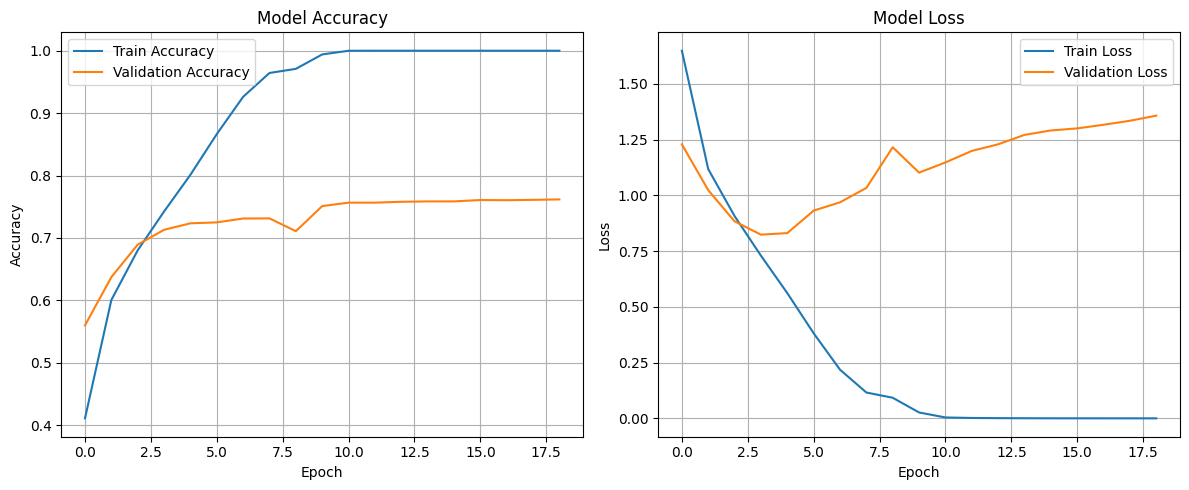

In [11]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Extract features using the feature extractor model
X_train_features = feature_extractor.predict(X_train_norm)
X_val_features = feature_extractor.predict(X_val_norm)
X_test_features = feature_extractor.predict(X_test_norm)

print(f"Feature shapes:")
print(f"Training features: {X_train_features.shape}")
print(f"Validation features: {X_val_features.shape}")
print(f"Test features: {X_test_features.shape}")

# Binarize the features (threshold at 0.5 for sigmoid activation)
X_train_bin = (X_train_features > 0.5).astype(np.uint32)
X_val_bin = (X_val_features > 0.5).astype(np.uint32)
X_test_bin = (X_test_features > 0.5).astype(np.uint32)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Feature shapes:
Training features: (40000, 4096)
Validation features: (10000, 4096)
Test features: (10000, 4096)


In [18]:
from sklearn.metrics import accuracy_score  # Import accuracy_score

# Initialize Tsetlin Machine with the specified parameters
print("\nInitializing Tsetlin Machine...")
tm = TMClassifier(
    number_of_clauses=1000, # C
    T=22,                   # T parameter
    s=16.0,                 # s parameter
    patch_dim=None,            # Not using patches for tabular data
    boost_true_positive_feedback=1,
    #number_of_state_bits=8,
    max_included_literals=X_train_bin.shape[1] # All features can be included
)

# Train Tsetlin Machine
print("\nTraining Tsetlin Machine on CNN-extracted features...")
y_train = y_train.astype(np.uint32)  # Convert y_train to uint32
tm.fit(X_train_bin, y_train, epochs=100, incremental=True)

# Evaluate on validation and test sets
y_pred_val = tm.predict(X_val_bin)
val_acc = 100 * accuracy_score(y_val, y_pred_val)

y_pred_test = tm.predict(X_test_bin)
test_acc = 100 * accuracy_score(y_test, y_pred_test)

print(f"Tsetlin Machine Validation Accuracy: {val_acc:.2f}%")
print(f"Tsetlin Machine Test Accuracy: {test_acc:.2f}%")


Initializing Tsetlin Machine...

Training Tsetlin Machine on CNN-extracted features...
Tsetlin Machine Validation Accuracy: 69.90%
Tsetlin Machine Test Accuracy: 68.99%


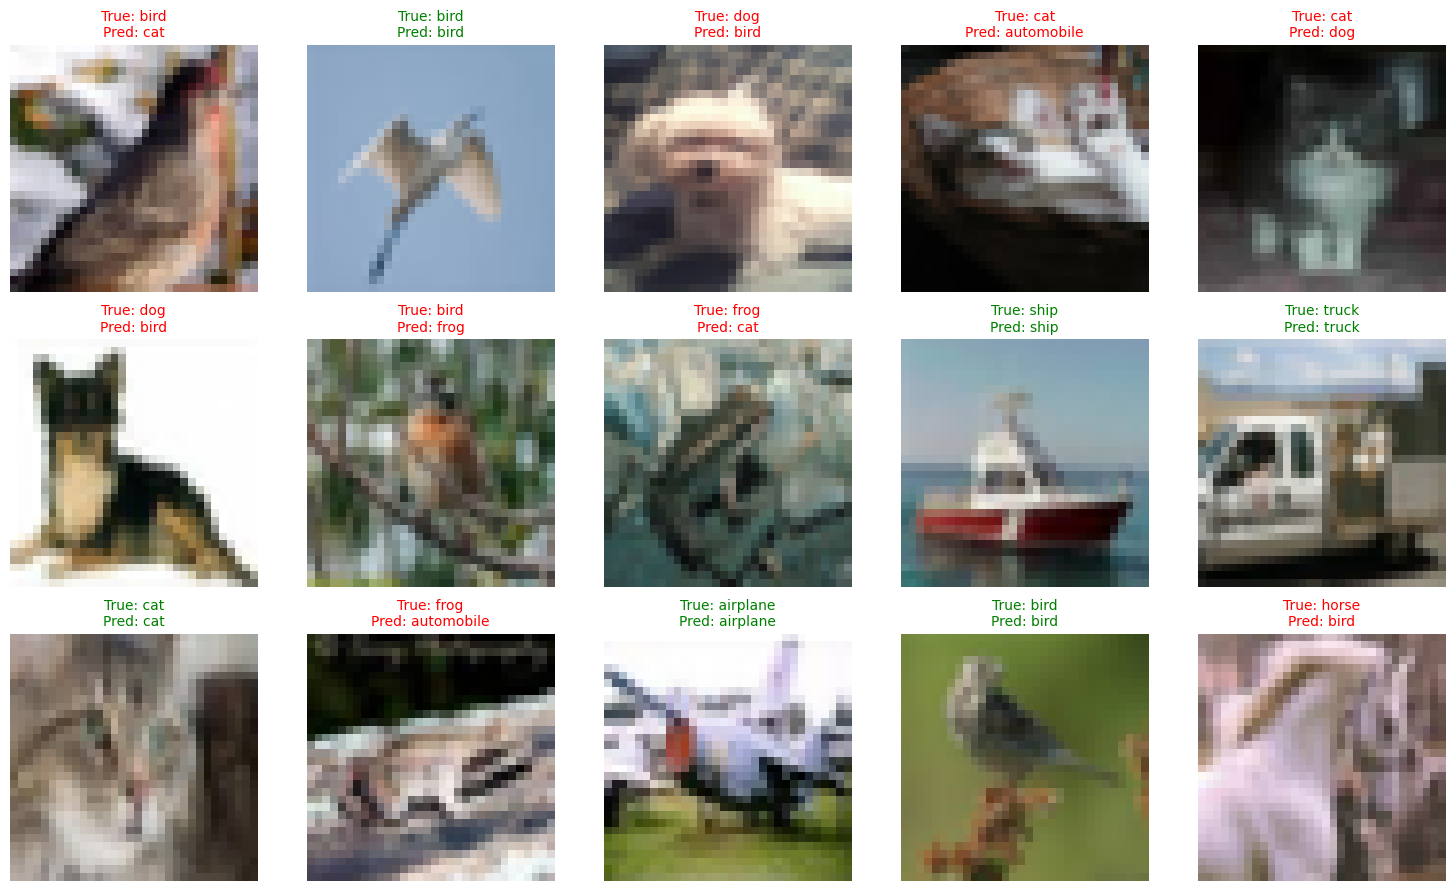

In [19]:
# Make predictions with Tsetlin Machine
y_pred_tm = tm.predict(X_test_bin)

# Select 15 random test samples
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)

# Create a figure with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()  # Flatten for easy iteration

for ax, idx in zip(axes, indices):
    img = X_test[idx]         # Original image for display
    true_label = y_test[idx]
    pred_label = y_pred_tm[idx]

    # Retrieve the actual class names
    true_class_name = class_mapping.get(true_label, 'Unknown')
    pred_class_name = class_mapping.get(pred_label, 'Unknown')

    # Display the image
    ax.imshow(img)

    # Set title color based on prediction correctness
    title_color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f"True: {true_class_name}\nPred: {pred_class_name}",
                 fontsize=10, color=title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()